In [1]:
# Import libraries

from datetime import datetime, timedelta
import warnings
import statsmodels.api as sm
import itertools
import seaborn as sns   
import os
from dateutil.parser import parse

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns
%matplotlib inline

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.regression.linear_model import OLS


# Load the data into a pandas dataframe. 
# This can be a csv file or you can choose to connect to a datasource of your choice
df = pd.read_csv('signups and spend GAC.csv')

# Convert the date column to a datetime object
df['date'] = pd.to_datetime(df['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     773 non-null    datetime64[ns]
 1   spend    773 non-null    float64       
 2   signups  773 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 18.2 KB


In [2]:
#check the start of the dataset
print(df.head())

#check the end of the dataset
print(df.tail())

        date        spend  signups
0 2021-01-01  5158.107971     5198
1 2021-01-02  6208.208169     6379
2 2021-01-03  8036.899649     7592
3 2021-01-04  4295.308506     3782
4 2021-01-05  3808.479745     3282
          date        spend  signups
768 2023-02-08  1548.226456     1776
769 2023-02-09  1551.105110     1735
770 2023-02-10  1865.782128     1880
771 2023-02-11  2338.652185     2490
772 2023-02-12  3619.207553     3847


In [3]:
# Remove outliers from the dataset
# Calculate the Z-score of each value in the data columns you are working with

z = np.abs(df['signups'] - df['signups'].mean()) / df['signups'].std()

df['z_score'] = z

df.head()

,date,spend,signups,z_score
0,2021-01-01,5158.107971,5198,0.040047
1,2021-01-02,6208.208169,6379,0.409698
2,2021-01-03,8036.899649,7592,0.789364
3,2021-01-04,4295.308506,3782,0.403158
4,2021-01-05,3808.479745,3282,0.559657


In [4]:
# Remove any rows which are more than 3 standard deviations away from the mean
df = df[z < 3]

In [5]:
# Set the date column as the index of the dataframe and the frequency as daily/weekly/monthly
df = df.set_index('date').asfreq('d')

# Sort the data by the index in ascending order
df = df.sort_index()

In [6]:
# Check if removed dates have been added back in (compare to first df.index above)
print(df.index)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-02-03', '2023-02-04', '2023-02-05', '2023-02-06',
               '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10',
               '2023-02-11', '2023-02-12'],
              dtype='datetime64[ns]', name='date', length=773, freq='D')


In [7]:
# Check which rows have null values since being added back in to the dataframe

np.isfinite(df['signups'])

df[df.index.isin(np.isfinite(df[['signups']]).query('not signups').index)]

,spend,signups,z_score
date,,,
2021-04-04,NaN,NaN,NaN
2021-04-05,NaN,NaN,NaN
2021-04-25,NaN,NaN,NaN
2021-05-01,NaN,NaN,NaN
2021-05-02,NaN,NaN,NaN
2022-07-24,NaN,NaN,NaN
2022-07-31,NaN,NaN,NaN
2022-08-07,NaN,NaN,NaN


In [8]:
# Fill in the blanks with the median values of the dataset

df[['signups', 'spend']] = df[['signups', 'spend']].fillna(df[['signups', 'spend']].mean())


# Reset the date index in order to be able to work with the date column for the next charts
df = df.reset_index()

# Remove the z score column
df = df.drop(columns=["z_score"])

df.head()

,date,spend,signups
0,2021-01-01,5158.107971,5198.0
1,2021-01-02,6208.208169,6379.0
2,2021-01-03,8036.899649,7592.0
3,2021-01-04,4295.308506,3782.0
4,2021-01-05,3808.479745,3282.0


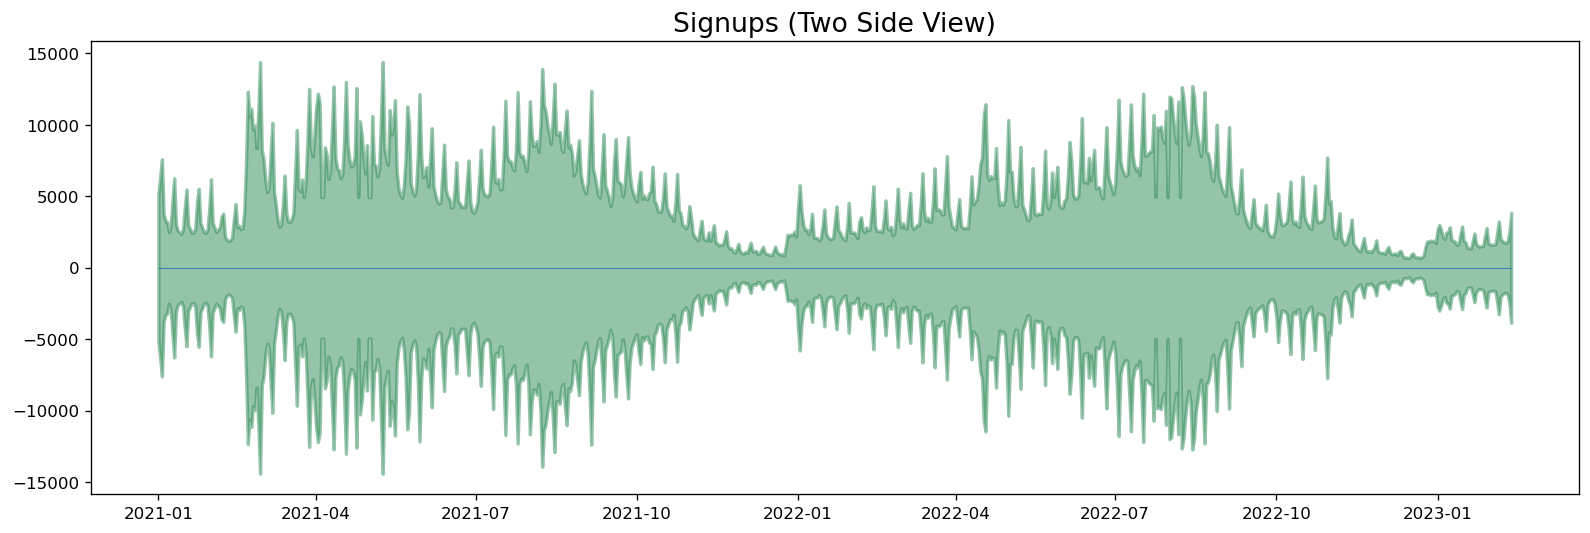

In [9]:
# View on a 2-side graph to examine growth of the metric

x = df['date'].values
y1 = df['signups'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.title('Signups (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df['date']), xmax=np.max(df['date']), linewidth=.5)
plt.show()

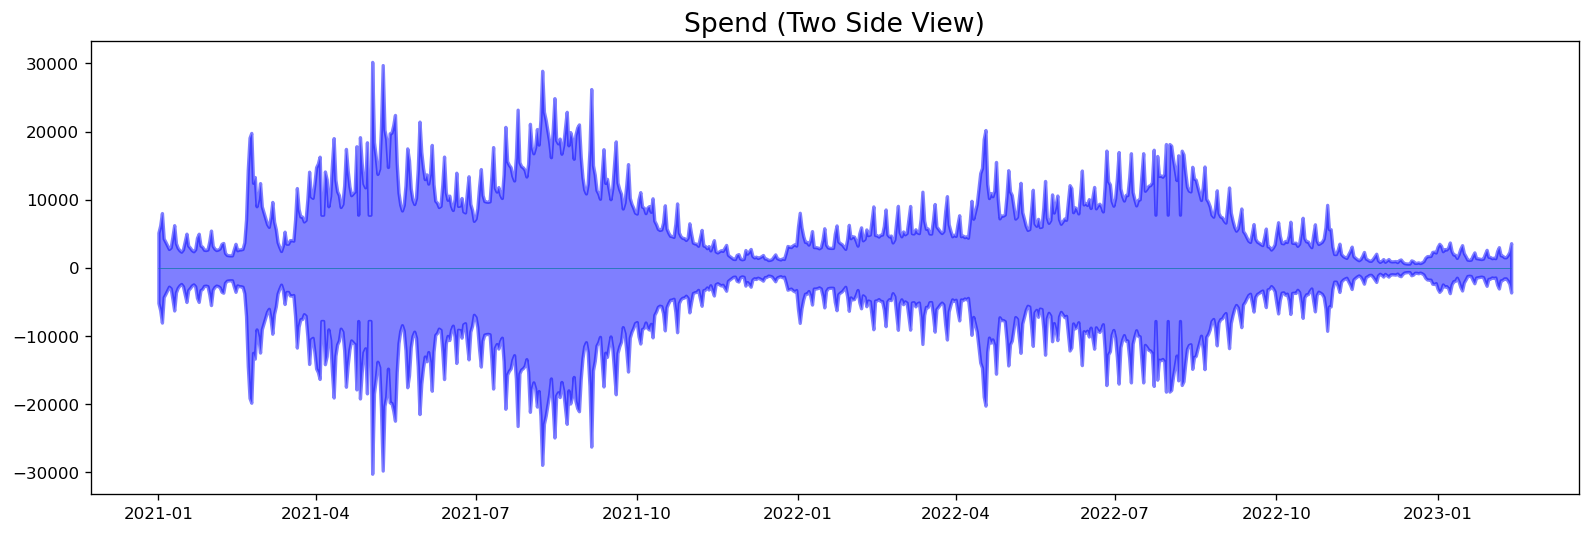

In [10]:
# View on a 2-side graph to examine growth of the metric

x = df['date'].values
y1 = df['spend'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='blue')
plt.title('Spend (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df['date']), xmax=np.max(df['date']), linewidth=.5)
plt.show()

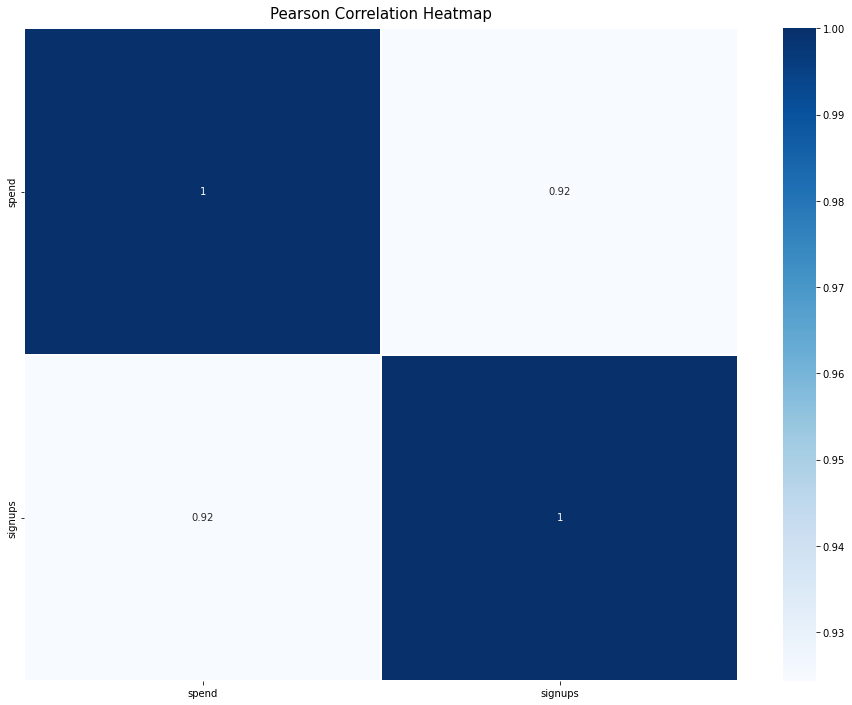

In [11]:
# check if there are any correlations between the columns in your data

def correlation_check(df: pd.DataFrame) -> None:
    """
    Plots a Pearson Correlation Heatmap.
    ---
    Args:
        df (pd.DataFrame): dataframe to plot
        
    Returns: None
    """
    
    # Figure
    fig, ax = plt.subplots(figsize=(16,12), facecolor='w')
    correlations_df = df.corr(method='pearson', min_periods=1)
    sns.heatmap(correlations_df, cmap="Blues", annot=True, linewidth=.1)

    # Labels
    ax.set_title("Pearson Correlation Heatmap", fontsize=15, pad=10)
    ax.set_facecolor(color='white')

correlation_check(df)

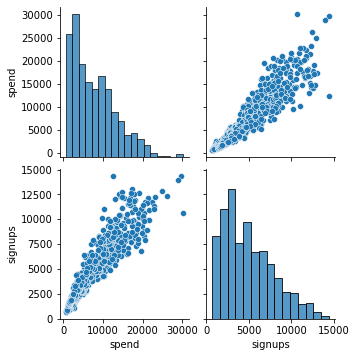

In [12]:
# A pairplot can also be used to check if any correlations between the data

sns.pairplot(data=df)

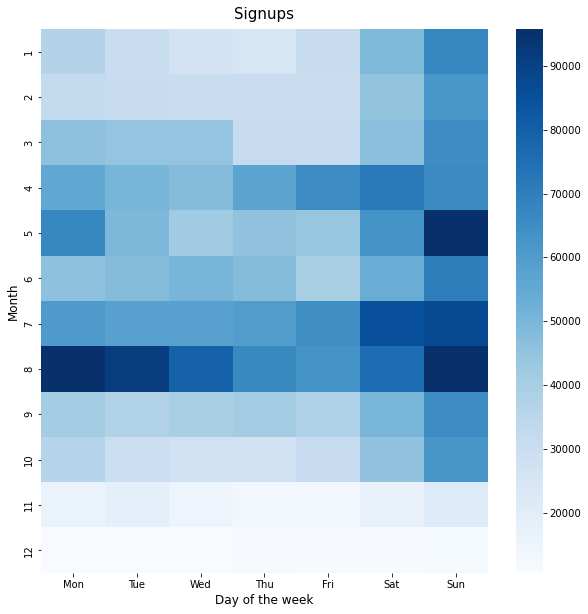

In [13]:
# plot a heatmap based on the seasonal pattern e.g. daily/weekly/monthly

def signups_heatmap(dataframe: pd.DataFrame) -> None:
    """
    This function plots the number of signups by weekday and month
    ---
    Args:
        dataframe (pd.DataFrame): Dataframe that contains the timeseries data

    Returns: None
    """
    # Data
    df = dataframe.copy(deep=False)

    # Reshaping data for the plot
    df["weekday"] = pd.DatetimeIndex(df['date']).weekday
    df["month"] = pd.DatetimeIndex(df['date']).month
    daily_activity = df.groupby(by=['month','weekday']).sum()['signups'].unstack()

    # Figure Object
    fig, ax = plt.subplots(figsize=(10,10), facecolor='w')
    xticklabels = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun"]
    sns.heatmap(daily_activity, robust=True, cmap="Blues", xticklabels=xticklabels)

    # Labeling
    ax.set_title("Signups", fontsize=15, pad=10)
    ax.set_xlabel("Day of the week", fontsize=12, x=.5)
    ax.set_ylabel("Month", fontsize=12, y=.5)
    
    plt.show()


signups_heatmap(df)

In [14]:
# Granger causality test is used to determine if one time series will be useful to forecast another.
# Use this if you want to test any exogenous variables e.g. time, spend, other variables

from statsmodels.tsa.stattools import grangercausalitytests

maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [15]:
# Call the Granger causality test function from above
grangers_causation_matrix(df, variables = df.columns)

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


InfeasibleTestError: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.

In [16]:
# Set the date column as the index of the dataframe and the frequency as daily/weekly/monthly
df = df.set_index('date').asfreq('d')

# Depending on the seasonality shown above, you can aggregate the data as required
# E.g. Select the time period and aggregate weekly to avoid weekly trend skewing analysis
df = df['2021-01-01':'2023-02-12'].resample('W').sum()

# Sort the data by the index in ascending order
df = df.sort_index()

In [17]:
#check the start of the dataset
print(df.head())

#check the end of the dataset
print(df.tail())

                   spend  signups
date                             
2021-01-03  19403.215789  19169.0
2021-01-10  27995.051072  26659.0
2021-01-17  23065.880074  22861.0
2021-01-24  23375.869305  23492.0
2021-01-31  23642.839544  23883.0
                   spend  signups
date                             
2023-01-15  15901.824134  14169.0
2023-01-22  11477.280315  12035.0
2023-01-29  11474.462858  12747.0
2023-02-05  13007.963298  13897.0
2023-02-12  14538.671126  15606.0


In [18]:
# Check the index settings are correct including the frequency
print(df.index)
print(df.info())

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2022-12-11', '2022-12-18', '2022-12-25', '2023-01-01',
               '2023-01-08', '2023-01-15', '2023-01-22', '2023-01-29',
               '2023-02-05', '2023-02-12'],
              dtype='datetime64[ns]', name='date', length=111, freq='W-SUN')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111 entries, 2021-01-03 to 2023-02-12
Freq: W-SUN
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   spend    111 non-null    float64
 1   signups  111 non-null    float64
dtypes: float64(2)
memory usage: 2.6 KB
None


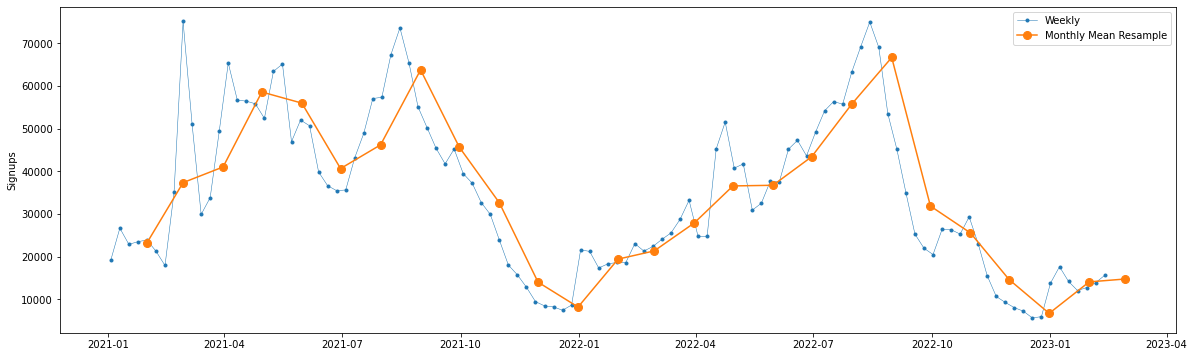

In [19]:
# Visualise the data and check trends including both weekly and monthly view
y = df['signups']

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Signups')
ax.legend();

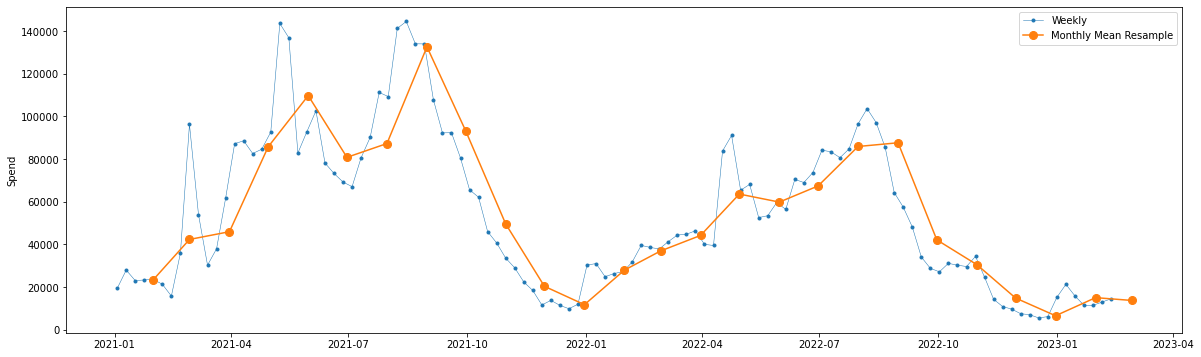

In [20]:
# Visualise the data and check trends including both weekly and monthly view
y2 = df['spend']

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y2,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y2.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Spend')
ax.legend();

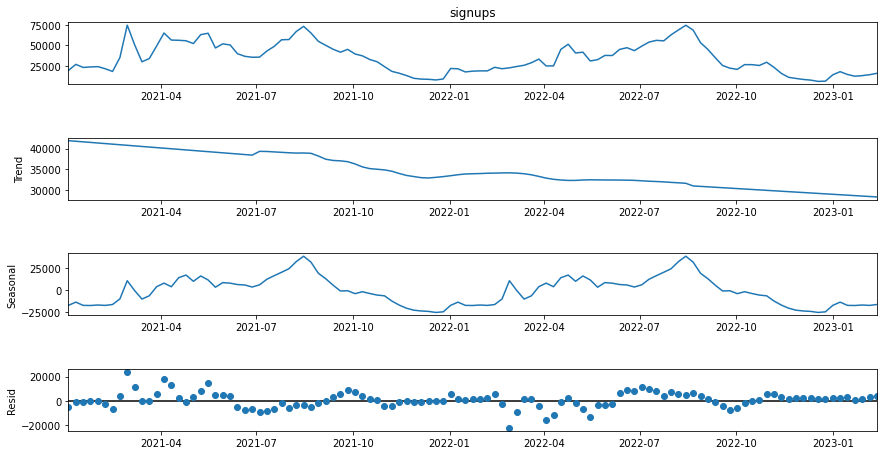

In [21]:
# Graphs to show seasonal_decompose using additive. Check and confirm if any trends remains in residual
def seasonal_decompose_add (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose_add(y)

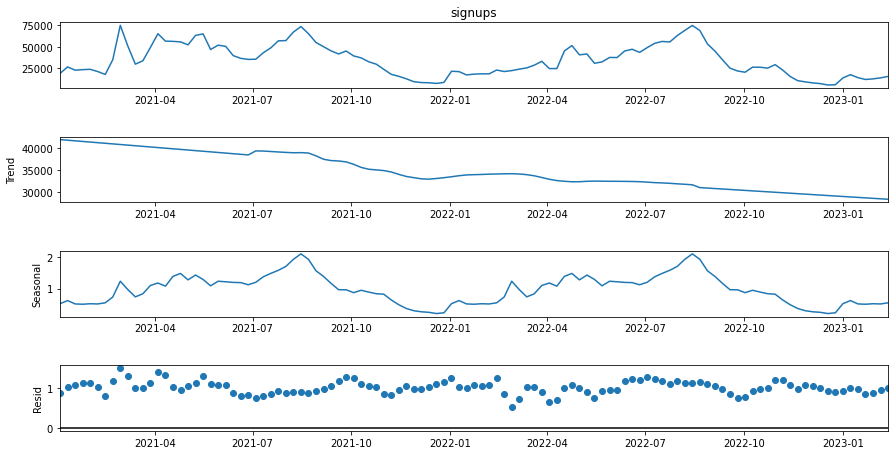

In [22]:
# Graphs to show seasonal_decompose using multiplicative. Check and confirm if any trends remains in residual
def seasonal_decompose_multi (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose_multi(y)

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


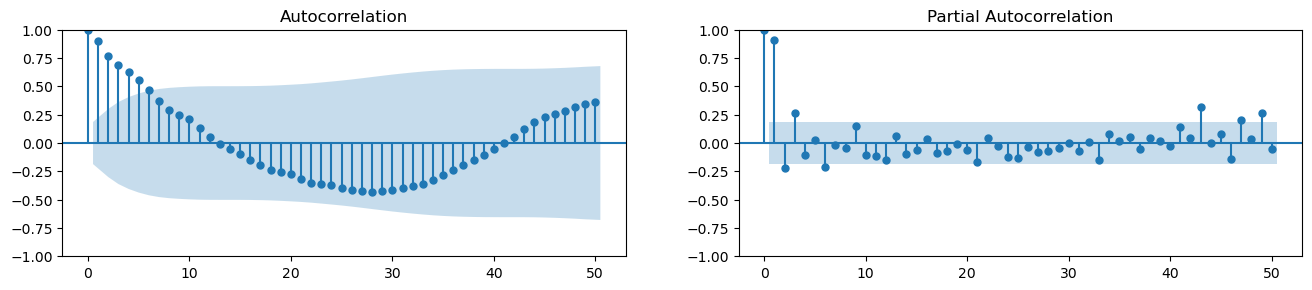

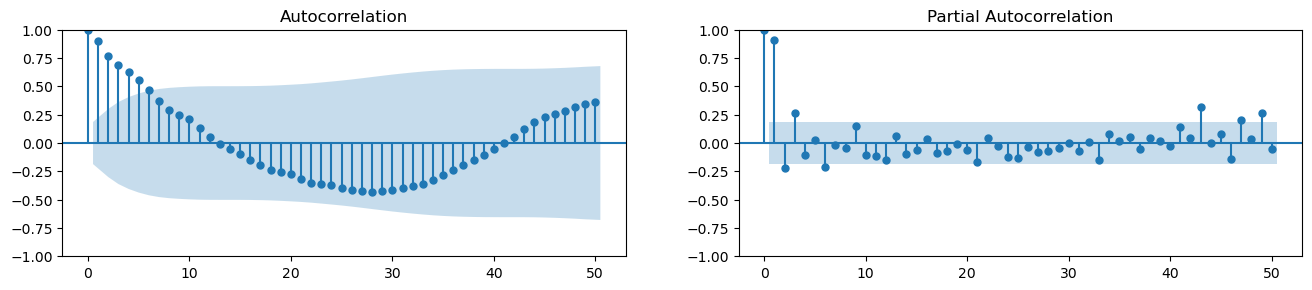

In [23]:
# check for autocorrelation or partial correlation

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['signups'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['signups'].tolist(), lags=50, ax=axes[1])

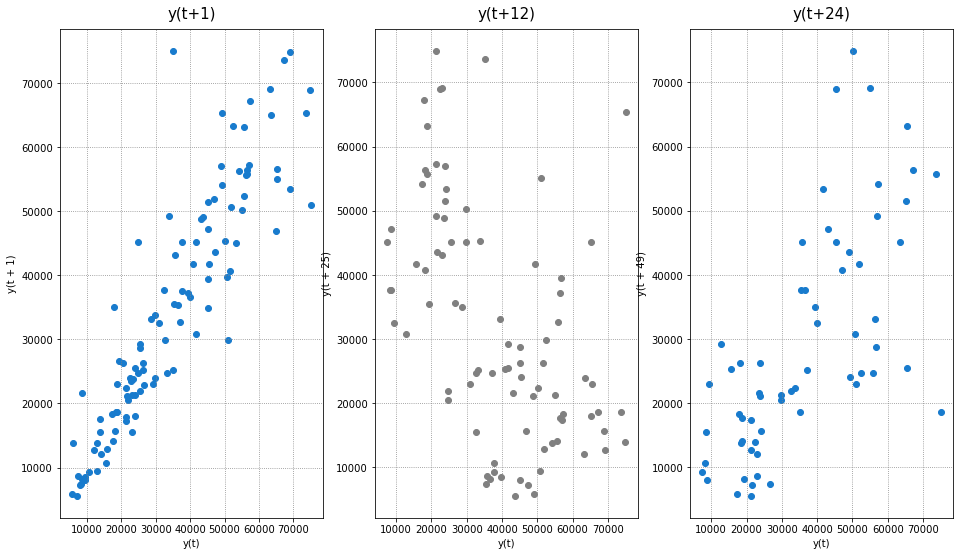

In [24]:
# Lag plot: use this to examine the above lags of interest in more detail 

def lag_plots(df: pd.DataFrame) -> None:
    """
    This function plots the correlation between
    current y(t) and y(t-1), y(t-12) and y(t-24) lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains a time series
        
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9), facecolor='w')
    
    # Lags
    lag_plot(df['signups'], lag=1, ax=ax1, c='#187bcd')
    lag_plot(df['signups'], lag=25, ax=ax2, c='grey')
    lag_plot(df['signups'], lag=49, ax=ax3, c='#187bcd')
    
    # Labels
    ax1.set_title("y(t+1)", fontsize=15, pad=10)
    ax2.set_title("y(t+12)", fontsize=15, pad=10)
    ax3.set_title("y(t+24)", fontsize=15, pad=10)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')
    ax3.grid(linestyle=":", color='grey')


lag_plots(df)

In [25]:
### plot for Rolling Statistic for testing whether the data is stationary. 
# This must be completed since are using an ARIMA model for forecasting
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

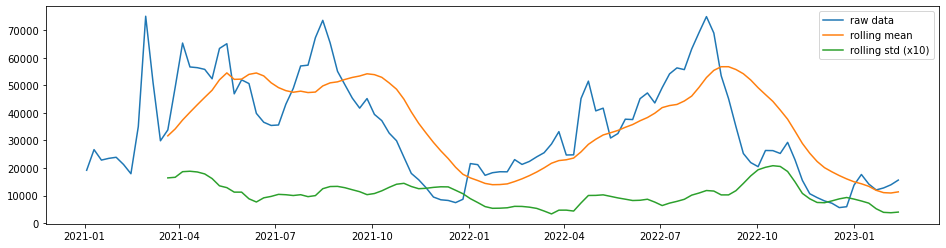

In [26]:
# Rolling statistics results
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [27]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [28]:
# Augmented Dickey-Fuller Test Results
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -2.367
P-value = 0.151
Critical values :
	1%: -3.4942202045135513 - The data is not stationary with 99% confidence
	5%: -2.889485291005291 - The data is not stationary with 95% confidence
	10%: -2.5816762131519275 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -3.332
P-value = 0.014
Critical values :
	1%: -3.5019123847798657 - The data is not stationary with 99% confidence
	5%: -2.892815255482889 - The data is  stationary with 95% confidence
	10%: -2.583453861475781 - The data is  stationary with 90% confidence


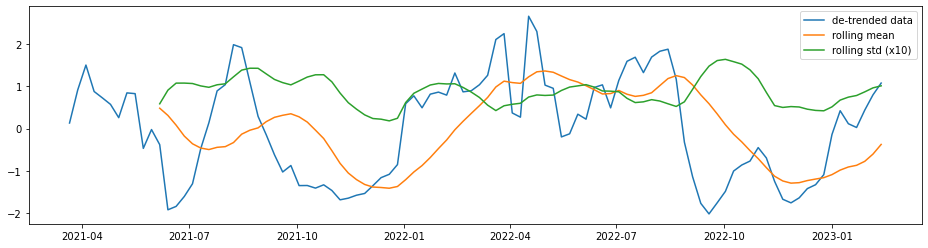

In [29]:
# Detrend the data in order to make stationary using a window which matches the seasonality of the dataset
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the lag differenced data stationary ?
Test statistic = -1.533
P-value = 0.517
Critical values :
	1%: -3.5087828609430614 - The data is not stationary with 99% confidence
	5%: -2.895783561573195 - The data is not stationary with 95% confidence
	10%: -2.5850381719848565 - The data is not stationary with 90% confidence


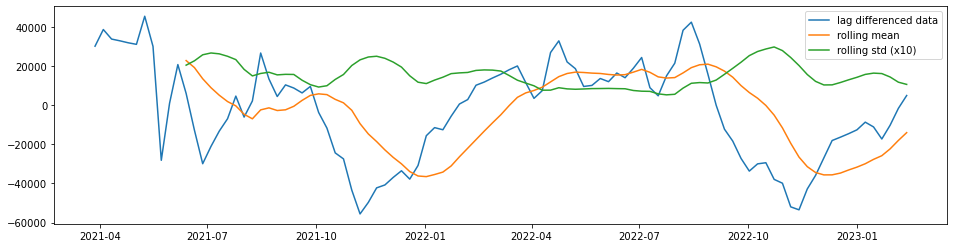

In [30]:
# Differencing using a shift which matches the seasonality of the dataset
y_lag =  y - y.shift(12)

test_stationarity(y_lag,'lag differenced data')
ADF_test(y_lag,'lag differenced data')

 > Is the lag differenced de-trended data stationary ?
Test statistic = -3.212
P-value = 0.019
Critical values :
	1%: -3.512738056978279 - The data is not stationary with 99% confidence
	5%: -2.8974898650628984 - The data is  stationary with 95% confidence
	10%: -2.585948732897085 - The data is  stationary with 90% confidence


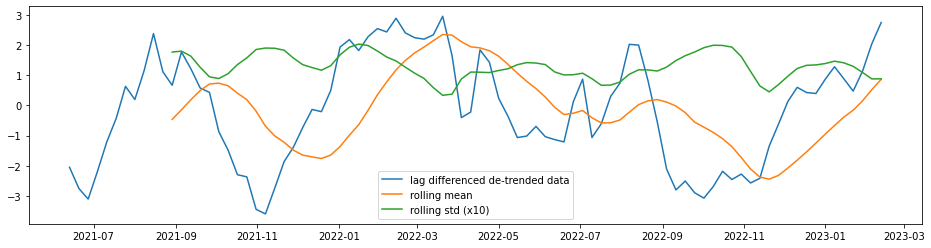

In [31]:
# Use Detrending + Differencing together to ensure data is stationary

y_lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_lag_detrend,'lag differenced de-trended data')
ADF_test(y_lag_detrend,'lag differenced de-trended data')

In [32]:
# Create a training dataset and a validation dataset

y_to_train = y[:'2023-01-30'] # dataset to train
y_to_val = y['2022-11-01':] # last X months for test  
predict_date = len(y) - len(y[:'2022-11-01']) # the number of data points for the test set

In [33]:
# Create a training dataset and a validation dataset for the exogenous variable

y2_to_train = y2[:'2023-01-30'] # dataset to train
y2_to_val = y2['2022-11-01':] # last X months for test  
predict_date = len(y2) - len(y2[:'2022-11-01']) # the number of data points for the test set

In [34]:
# Complete a sarima grid search to find the right hyperparameters 
# for both the trend and seasonal elements of the series

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, 
                                                exog=y2,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [35]:
# Run the sarima grid search and change the seasonal period to what best fits the dataset

sarima_grid_search(y,52)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21667D+01    |proj g|=  1.89780D-04

At iterate    5    f=  1.21491D+01    |proj g|=  1.23473D-01

At iterate   10    f=  1.12360D+01    |proj g|=  7.16876D+00

At iterate   15    f=  1.03283D+01    |proj g|=  3.90515D-01

At iterate   20    f=  1.03245D+01    |proj g|=  2.07180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     46      1     0     0   2.072D-04   1.032D+01
  F =   10.324504077311595     

CONVERG

 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  5.24204D+00    |proj g|=  1.59237D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   4.497D-05   5.241D+00
  F =   5.2414944747769221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35837D+00    |proj g|=  1.94235D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   6.740D-06   6.358D+00
  F =   6.3583659414004519     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.4

 This problem is unconstrained.



At iterate    5    f=  5.46649D-01    |proj g|=  1.83713D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     11      1     0     0   5.477D-06   5.466D-01
  F =  0.54664852820451115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37405D+00    |proj g|=  3.90300D+00

At iterate    5    f=  5.25542D+00    |proj g|=  3.98583D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.986D-05   5.255D+00
  F =   5.2554193620816960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33013D+00    |proj g|=  1.95687D+00

At iterate    5    f=  5.24114D+00    |proj g|=  2.40655D-02

At iterate   10    f=  5.24109D+00    |proj g|=  2.76776D-02

At iterate   15    f=  5.23891D+00    |proj g|=  2.05490D-01

At iterate   20    f=  5.23717D+00    |proj g|=  1.67056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   1.014D-04   5.237D+00
  F =   5.2371663297044106     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  5.44112D-01    |proj g|=  3.56805D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   3.568D-06   5.441D-01
  F =  0.54411171231758726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46726D-01    |proj g|=  1.01934D-03

At iterate    5    f=  5.46650D-01    |proj g|=  1.05725D-04

At iterate   10    f=  5.46649D-01    |proj g|=  2.99166D-04

At iterate   15    f=  5.46647D-01    |proj g|=  7.64106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   5.477D-06   5.466D-01
  F =  0.54664728529529794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00724D+01    |proj g|=  4.22388D+00

At iterate    5    f=  9.89003D+00    |proj g|=  1.15156D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   6.042D-05   9.890D+00
  F =   9.8900070017906980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34867D+00    |proj g|=  9.00215D-01

At iterate    5    f=  5.32237D+00    |proj g|=  4.39766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.995D-05   5.322D+00
  F =   5.3223729764511809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52216D-01    |proj g|=  4.56760D-02

At iterate    5    f=  4.48098D-01    |proj g|=  6.35916D-05

At iterate   10    f=  4.48090D-01    |proj g|=  1.00323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     24      1     0     0   9.766D-06   4.481D-01
  F =  0.44808999642430075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  5.25719D+00    |proj g|=  6.26022D-02

At iterate   10    f=  5.25664D+00    |proj g|=  6.25690D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   5.980D-05   5.257D+00
  F =   5.2566392002331011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18955D+00    |proj g|=  1.78719D+00


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  5.07994D+00    |proj g|=  3.50087D-03

At iterate   10    f=  5.07985D+00    |proj g|=  7.52771D-03

At iterate   15    f=  5.07964D+00    |proj g|=  2.60373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   5.747D-05   5.080D+00
  F =   5.0796448543939992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33087D-01    |proj g|=  6.68880D-02


 This problem is unconstrained.



At iterate    5    f=  6.27325D-01    |proj g|=  2.12220D-03

At iterate   10    f=  6.27193D-01    |proj g|=  1.05565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     34      1     0     0   9.881D-06   6.272D-01
  F =  0.62719057449648485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52216D-01    |proj g|=  4.56760D-02

At iterate    5    f=  4.48102D-01    |proj g|=  2.22712D-04

At iterate   10    f=  4.48099D-01    |proj g|=  1.39717D-04

At iterate   15    f=  4.48092D-01    |proj g|=  1.89425D-04

At iterate   20    f=  4.48045D-01    |proj g|=  1.95015D-03

At iterate   25    f=  4.48014D-01    |proj g|=  3.31478D-04

At iterate   30    f=  4.48013D-01    |proj g|=  5.24811D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.82963D+00    |proj g|=  1.93610D-04

At iterate   10    f=  4.82959D+00    |proj g|=  1.39672D-02

At iterate   15    f=  4.82527D+00    |proj g|=  1.64082D-01

At iterate   20    f=  4.77631D+00    |proj g|=  7.80362D-03

At iterate   25    f=  4.77528D+00    |proj g|=  9.28591D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   9.286D-07   4.775D+00
  F =   4.7752789062012306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90525D+00    |proj g|=  2.03922D-04

At iterate    5    f=  5.82934D+00    |proj g|=  1.91982D-01

At iterate   10    f=  5.56961D+00    |proj g|=  1.04807D+00

At iterate   15    f=  5.11664D+00    |proj g|=  5.85979D-02

At iterate   20    f=  5.11624D+00    |proj g|=  5.06235D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     58      1     0     0   5.062D-06   5.116D+00
  F =   5.1162419884773742     

CONVERG

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26994D-01    |proj g|=  2.05843D-03

At iterate    5    f=  4.26699D-01    |proj g|=  3.87236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   8.501D-06   4.267D-01
  F =  0.42669136933776602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  4.85532D+00    |proj g|=  1.11916D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.119D-05   4.855D+00
  F =   4.8553163428427260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83750D+00    |proj g|=  2.21584D-01


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.82963D+00    |proj g|=  2.43707D-04

At iterate   10    f=  4.82960D+00    |proj g|=  5.49790D-04

At iterate   15    f=  4.82960D+00    |proj g|=  6.80144D-04

At iterate   20    f=  4.82900D+00    |proj g|=  1.49578D-02

At iterate   25    f=  4.80303D+00    |proj g|=  2.06138D-01

At iterate   30    f=  4.76932D+00    |proj g|=  2.66261D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     44      1     0     0   3.138D-06   4.769D+00
  F =   4.7693178665361122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53484D-01    |proj g|=  1.09900D-02

At iterate    5    f=  4.46965D-01    |proj g|=  6.58878D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     17      1     0     0   1.257D-05   4.468D-01
  F =  0.44679136720537915     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26994D-01    |proj g|=  2.05843D-03

At iterate    5    f=  4.26743D-01    |proj g|=  2.29017D-03

At iterate   10    f=  4.26335D-01    |proj g|=  1.19968D-03

At iterate   15    f=  4.25966D-01    |proj g|=  4.09348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   8.789D-06   4.260D-01
  F =  0.42596404757429440     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.74762D+00    |proj g|=  4.77277D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   7.040D-05   4.748D+00
  F =   4.7476172777036103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02642D+00    |proj g|=  3.47463D-02

At iterate    5    f=  5.02550D+00    |proj g|=  4.31131D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   4.311D-06   5.026D+00
  F =   5.0255030798972307     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42843D-01    |proj g|=  1.14762D-03

At iterate    5    f=  3.42336D-01    |proj g|=  3.04324D-04

At iterate   10    f=  3.42317D-01    |proj g|=  6.66210D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   6.662D-06   3.423D-01
  F =  0.34231663416191332     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.92096D+00    |proj g|=  1.78498D-01

At iterate    5    f=  4.91365D+00    |proj g|=  1.03395D-03

At iterate   10    f=  4.91365D+00    |proj g|=  4.71591D-04

At iterate   15    f=  4.91363D+00    |proj g|=  6.10101D-03

At iterate   20    f=  4.91130D+00    |proj g|=  6.78068D-02

At iterate   25    f=  4.85840D+00    |proj g|=  1.89766D-01

At iterate   30    f=  4.84746D+00    |proj g|=  7.26184D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75533D+00    |proj g|=  1.87940D-01

At iterate    5    f=  4.74763D+00    |proj g|=  5.71415D-03

At iterate   10    f=  4.74762D+00    |proj g|=  3.41217D-04

At iterate   15    f=  4.74761D+00    |proj g|=  2.31170D-03

At iterate   20    f=  4.74760D+00    |proj g|=  7.04667D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   7.047D-05   4.748D+00
  F =   4.7476023845976174     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  5.13154D-01    |proj g|=  1.02373D-04

At iterate   10    f=  5.13154D-01    |proj g|=  4.00642D-05

At iterate   15    f=  5.13139D-01    |proj g|=  3.03901D-04

At iterate   20    f=  5.12420D-01    |proj g|=  7.27493D-03

At iterate   25    f=  4.46258D-01    |proj g|=  2.08697D-02

At iterate   30    f=  4.32024D-01    |proj g|=  9.61731D-03

At iterate   35    f=  4.31552D-01    |proj g|=  1.35581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     58      1     0     0   4.145D-06   4.316D-01
  F =  0.43155181339034970     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42843D-01    |proj g|=  1.14762D-03

At iterate    5    f=  3.42029D-01    |proj g|=  1.30411D-03

At iterate   10    f=  3.41840D-01    |proj g|=  1.96152D-04

At iterate   15    f=  3.41758D-01    |proj g|=  2.82264D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   7.869D-06   3.418D-01
  F =  0.34175683805525447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62122D+00    |proj g|=  1.21581D+00

At iterate    5    f=  9.56704D+00    |proj g|=  4.74151D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   6.254D-05   9.567D+00
  F =   9.5670361185419761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15902D-01    |proj g|=  3.96589D-03

At iterate    5    f=  5.15170D-01    |proj g|=  5.77788D-04

At iterate   10    f=  5.15115D-01    |proj g|=  2.83406D-03

At iterate   15    f=  5.14876D-01    |proj g|=  1.72310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   9.794D-06   5.149D-01
  F =  0.51487347569921615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  4.92189D+00    |proj g|=  6.10597D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   7.591D-05   4.922D+00
  F =   4.9218438824912472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.92430D+00    |proj g|=  6.24103D-02

At iterate    5    f=  4.92185D+00    |proj g|=  2.88271D-03

At iterate   10    f=  4.92185D+00    |proj g|=  1.02545D-03

At iterate   15    f=  4.92178D+00    |proj g|=  3.22554D-02

At iterate   20    f=  4.92139D+00    |proj g|=  1.29452D-03

At iterate   25    f=  4.92138D+00    |proj g|=  1.41495D-03

At iterate   30    f=  4.92110D+00    |proj g|=  2.39173D-02

At iterate   35    f=  4.89287D+00    |proj g|=  2.50529D-01

At iterate   40    f=  4.84595D+00    |proj g|=  2.39067D-02

At iterate   45    f=  4.84311D+00    |proj g|=  7.20729D-02


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.84040D+00    |proj g|=  5.12537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   5.125D-03   4.840D+00
  F =   4.8404032165401958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.16083D-01    |proj g|=  4.48504D-03

At iterate    5    f=  5.15137D-01    |proj g|=  5.49699D-04

At iterate   10    f=  5.15039D-01    |proj g|=  1.53175D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   9.733D-06   5.150D-01
  F =  0.51503947358083968     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15902D-01    |proj g|=  3.96589D-03

At iterate    5    f=  5.15182D-01    |proj g|=  3.00022D-04

At iterate   10    f=  5.15161D-01    |proj g|=  1.24247D-03

At iterate   15    f=  5.15044D-01    |proj g|=  1.03705D-02

At iterate   20    f=  5.14870D-01    |proj g|=  3.13038D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     34      1     0     0   1.945D-05   5.149D-01
  F =  0.51487024872347287     

CONVERG

 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53108D+00    |proj g|=  1.22361D+00

At iterate    5    f=  9.47356D+00    |proj g|=  2.54732D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.450D-04   9.473D+00
  F =   9.4726810729557869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  5.09053D+00    |proj g|=  6.20908D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   1.448D-05   5.091D+00
  F =   5.0905307233403700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28294D-01    |proj g|=  1.60317D-03

At iterate    5    f=  4.28070D-01    |proj g|=  1.75026D-04

At iterate   10    f=  4.28056D-01    |proj g|=  6.43048D-05

At iterate   15    f=  4.27895D-01    |proj g|=  1.36323D-03

At iterate   20    f=  4.27880D-01    |proj g|=  6.91497D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     38      1     0     0   8.388D-06   4.279D-01
  F =  0.42787976887295365     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93380D+00    |proj g|=  1.25428D-01

At iterate    5    f=  4.92049D+00    |proj g|=  2.43199D-02

At iterate   10    f=  4.92004D+00    |proj g|=  7.78996D-05

At iterate   15    f=  4.92004D+00    |proj g|=  9.57851D-04

At iterate   20    f=  4.91979D+00    |proj g|=  1.52709D-02

At iterate   25    f=  4.90238D+00    |proj g|=  1.81528D-01

At iterate   30    f=  4.87610D+00    |proj g|=  8.54808D-02

At iterate   35    f=  4.84166D+00    |proj g|=  1.06091D-01

At iterate   40    f=  4.83846D+00    |proj g|=  7.76304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84121D+00    |proj g|=  6.71166D-02

At iterate    5    f=  4.83703D+00    |proj g|=  1.61626D-02

At iterate   10    f=  4.83675D+00    |proj g|=  9.03529D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   7.578D-05   4.837D+00
  F =   4.8367549918421080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14955D-01    |proj g|=  6.19170D-03

At iterate    5    f=  5.13570D-01    |proj g|=  5.07136D-04

At iterate   10    f=  5.13087D-01    |proj g|=  2.20567D-04

At iterate   15    f=  5.13080D-01    |proj g|=  1.01701D-05

At iterate   20    f=  5.13076D-01    |proj g|=  2.01025D-04

At iterate   25    f=  5.12677D-01    |proj g|=  1.50551D-03

At iterate   30    f=  5.10298D-01    |proj g|=  2.06797D-02

At iterate   35    f=  5.06548D-01    |proj g|=  1.08159D-02

At iterate   40    f=  5.02880D-01    |proj g|=  2.08970D-02

At iterate   45    f=  4.99255D-01    |proj g|=  5.00836D-02


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.98775D-01    |proj g|=  1.90999D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     87      1     0     0   1.910D-02   4.988D-01
  F =  0.49877500256280310     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28294D-01    |proj g|=  1.60317D-03


 This problem is unconstrained.



At iterate    5    f=  4.28058D-01    |proj g|=  1.35436D-04

At iterate   10    f=  4.27956D-01    |proj g|=  1.85498D-03

At iterate   15    f=  4.27488D-01    |proj g|=  1.14530D-03

At iterate   20    f=  4.27425D-01    |proj g|=  2.38770D-04

At iterate   25    f=  4.27412D-01    |proj g|=  6.60033D-05

At iterate   30    f=  4.27393D-01    |proj g|=  1.76835D-04

At iterate   35    f=  4.27362D-01    |proj g|=  1.92885D-04

At iterate   40    f=  4.27359D-01    |proj g|=  2.09164D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     58      1     0     0   1.115D-05   4.274D-01
  F =  0.427359146156

 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.82801D+00    |proj g|=  6.78330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   7.153D-05   4.828D+00
  F =   4.8280085425413750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11317D+00    |proj g|=  3.13289D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   5.924D-08   5.113D+00
  F =   5.1131043100608728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.27166D-01    |proj g|=  1.13935D-03

At iterate    5    f=  4.26819D-01    |proj g|=  6.72732D-04

At iterate   10    f=  4.26545D-01    |proj g|=  1.36934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   8.606D-06   4.265D-01
  F =  0.42654444449605894     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   7.153D-05   4.828D+00
  F =   4.8280084322490833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83603D+00    |proj g|=  2.02237D-01

At iterate    5    f=  4.82801D+00    |proj g|=  3.87818D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   7.153D-05   4.828D+00
  F =   4.8280085010081057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.27077D-01    |proj g|=  7.72341D-04

At iterate    5    f=  4.26620D-01    |proj g|=  2.28724D-04

At iterate   10    f=  4.26322D-01    |proj g|=  7.28590D-04

At iterate   15    f=  4.26010D-01    |proj g|=  5.05593D-04

At iterate   20    f=  4.26007D-01    |proj g|=  4.02933D-05

At iterate   25    f=  4.26000D-01    |proj g|=  1.53922D-03

At iterate   30    f=  4.23073D-01    |proj g|=  2.52529D-03

At iterate   35    f=  4.08942D-01    |proj g|=  1.04392D-02

At iterate   40    f=  3.82745D-01    |proj g|=  1.64486D-02

At iterate   45    f=  3.76941D-01    |proj g|=  6.51893D-02


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.63235D-01    |proj g|=  2.67106D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     81      1     0     0   2.671D-02   3.632D-01
  F =  0.36323532037743950     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.27166D-01    |proj g|=  1.13935D-03

At iterate    5    f=  4.26584D-01    |proj g|=  1.18259D-03

At iterate   10    f=  4.26422D-01    |proj g|=  1.15314D-04

At iterate   15    f=  4.26098D-01    |proj g|=  4.52053D-03

At iterate   20    f=  4.26006D-01    |proj g|=  4.19412D-05

At iterate   25    f=  4.26006D-01    |proj g|=  5.40518D-05

At iterate   30    f=  4.26002D-01    |proj g|=  1.92330D-03

At iterate   35    f=  4.25666D-01    |proj g|=  2.41769D-03

At iterate   40    f=  4.20859D-01    |proj g|=  8.49025D-03

At iterate   45    f=  3.91678D-01    |proj g|=  7.51354D-02


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.47816D-01    |proj g|=  4.46668D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     87      1     0     0   4.467D-02   3.478D-01
  F =  0.34781562713375108     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40776D+00    |proj g|=  6.96580D-02

At iterate    5    f=  9.40198D+00    |proj g|=  7.39741D-02

At iterate   10    f=  9.39545D+00    |proj g|=  2.44507D-05

       

 This problem is unconstrained.
/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.74746D+00    |proj g|=  1.35886D-03

At iterate   10    f=  4.74739D+00    |proj g|=  2.69222D-03

At iterate   15    f=  4.74738D+00    |proj g|=  1.43102D-04

At iterate   20    f=  4.74738D+00    |proj g|=  2.49922D-03

At iterate   25    f=  4.74692D+00    |proj g|=  2.52919D-02

At iterate   30    f=  4.71023D+00    |proj g|=  5.46734D-02

At iterate   35    f=  4.68650D+00    |proj g|=  2.74338D-02

At iterate   40    f=  4.68604D+00    |proj g|=  6.34139D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     56      1     0     0   1.839D-05   4.686D+00
  F =   4.68604235983

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02676D+00    |proj g|=  3.40080D-02

At iterate    5    f=  5.02546D+00    |proj g|=  2.51500D-02

At iterate   10    f=  5.02332D+00    |proj g|=  5.38678D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   5.139D-06   5.023D+00
  F =   5.0233167331834929     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42845D-01    |proj g|=  1.11092D-03

At iterate    5    f=  3.42289D-01    |proj g|=  3.25817D-04

At iterate   10    f=  3.42229D-01    |proj g|=  3.97108D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     19      1     0     0   6.694D-06   3.422D-01
  F =  0.34221610796636165     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  4.83019D+00    |proj g|=  1.40091D-03

At iterate   10    f=  4.83011D+00    |proj g|=  7.27656D-05

At iterate   15    f=  4.83010D+00    |proj g|=  2.37083D-03

At iterate   20    f=  4.82841D+00    |proj g|=  8.42103D-02

At iterate   25    f=  4.78105D+00    |proj g|=  3.43462D-01

At iterate   30    f=  4.76679D+00    |proj g|=  4.98575D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   7.963D-06   4.767D+00
  F =   4.7667538133776564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *



/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75512D+00    |proj g|=  1.88476D-01

At iterate    5    f=  4.74746D+00    |proj g|=  1.39114D-03

At iterate   10    f=  4.74739D+00    |proj g|=  1.63436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   7.045D-05   4.747D+00
  F =   4.7473847979884480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28201D-01    |proj g|=  8.07439D-04

At iterate    5    f=  4.27691D-01    |proj g|=  5.45579D-04

At iterate   10    f=  4.27405D-01    |proj g|=  2.19100D-04

At iterate   15    f=  4.27376D-01    |proj g|=  8.74664D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     24      1     0     0   8.747D-06   4.274D-01
  F =  0.42737607720813592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42845D-01    |proj g|=  1.11092D-03

At iterate    5    f=  3.41982D-01    |proj g|=  8.00821D-04

At iterate   10    f=  3.41840D-01    |proj g|=  2.58185D-04

At iterate   15    f=  3.41759D-01    |proj g|=  2.69078D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     27      1     0     0   7.948D-06   3.418D-01
  F =  0.34175617323129726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The set 

In [36]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC

def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test,y2_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                    exog = y2,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), exog=y2, dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    # Using MAPE error metrics to check for the error rate and accuracy level
    LR_MAPE = MAPE(y,y_forecasted)
    print("MAPE: ",LR_MAPE)
    
    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Signups')
    plt.legend()
    plt.show()
    

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), exog=y2, dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    # Using MAPE error metrics to check for the error rate and accuracy level
    LR_MAPE = MAPE(y,y_forecasted_dynamic)
    print("MAPE: ",LR_MAPE)
    
    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Signups')

    plt.legend()
    plt.show()
    
    return (results)

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19974D+00    |proj g|=  3.51694D-01

At iterate    5    f=  5.08895D+00    |proj g|=  5.00763D-03

At iterate   10    f=  5.08889D+00    |proj g|=  5.61448D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   5.614D-05   5.089D+00
  F =   5.0888913924217807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025    

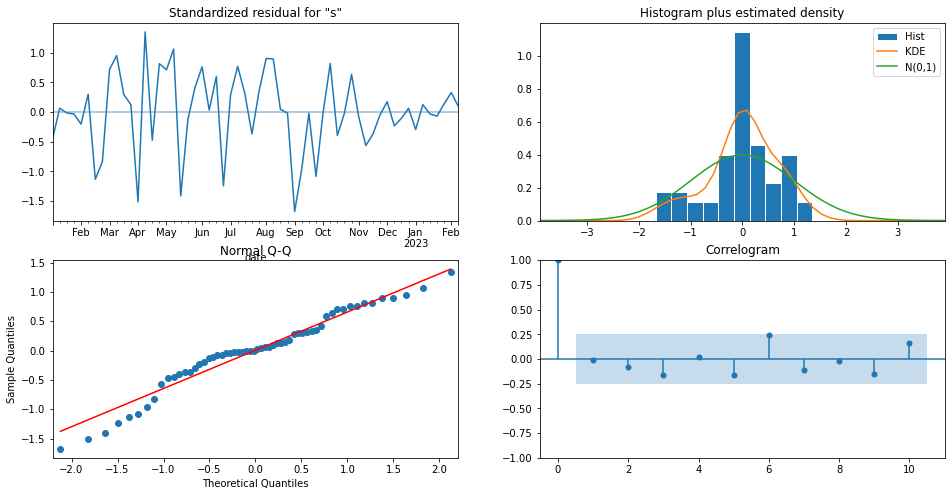

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 1264.89


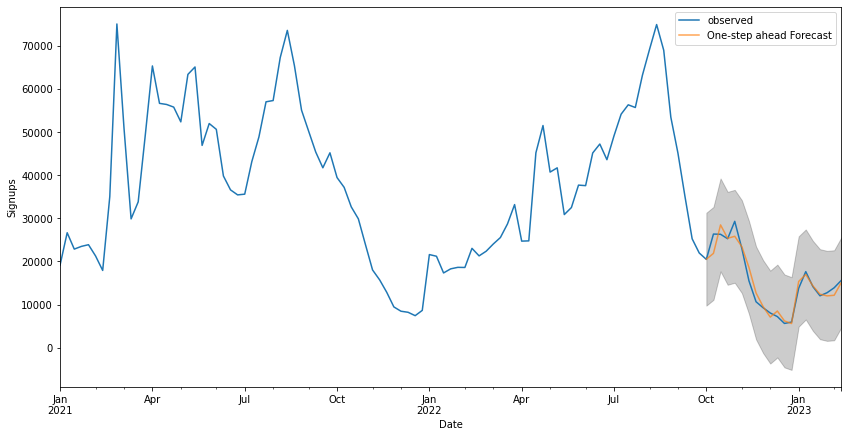

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 2341.59


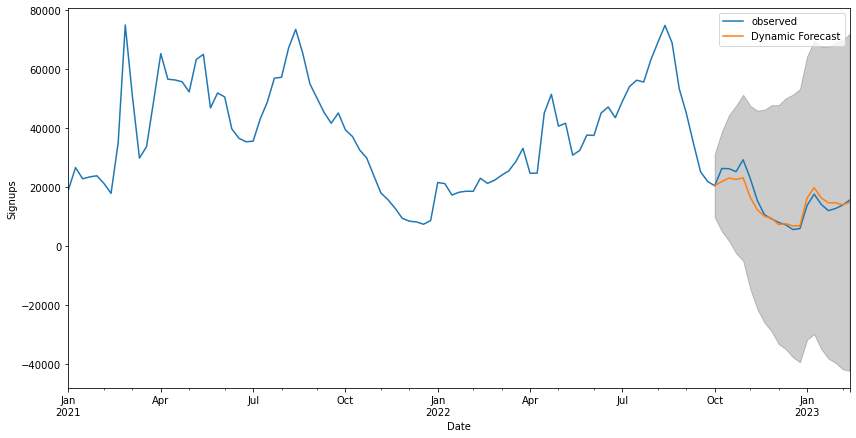

In [37]:
# Update the sarima parameters using the results of the sarima grid search

model = sarima_eva(y,(0, 1, 1),(0, 1, 1,52),52,'2022-10-02',y_to_val,y2_to_val)

In [38]:
# Create the forecast function

def forecast(model,predict_steps,y,y2):
    
    
    pred_uc = model.get_forecast(steps=predict_steps,exog=y2_to_train, dynamic=True)

    #SARIMA results.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

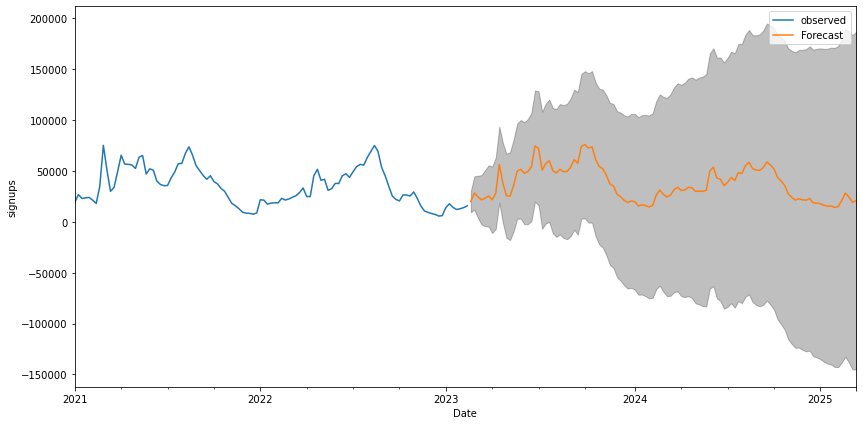

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2023-02-19,19773.51616652,9337.53064547,30209.50168757
1,2023-02-26,28238.01844797,11845.90282898,44630.13406696
2,2023-03-05,24518.23035784,3818.17379288,45218.28692280
3,2023-03-12,21509.03265680,-2745.52129318,45763.58660678
4,2023-03-19,23158.78926767,-4192.15953621,50509.73807156


In [39]:
# Create the forecast table for the chosen future period. 
# The forecast period must be the same size as the training dataset for the exogenous variable

final_table = forecast(model,109,y,y2)
final_table.head()

In [40]:
# save the final forecasts table as a csv or excel file

final_table.to_csv('final forecast table exogenous variable.csv')
final_table.to_excel('final forecast table exogenous variable excel.xlsx')